In [1]:
from environments import get_environment_builder
import numpy as np
from pydrake.all import (RigidTransform,
                         RotationMatrix, 
                         InverseKinematics,
                         MathematicalProgram,
                         Solve,
                         Cylinder,
                         Rgba,
                         RollPitchYaw)

import ipywidgets as widgets
from functools import partial
from visibility_utils import (get_col_func, 
                              get_sample_cfree_handle,
                              get_coverage_estimator,
                              vgraph,
                              point_in_regions)
from pydrake.all import SceneGraphCollisionChecker, IrisOptions
from visibility_logging import CliqueApproachLogger
from visibility_clique_decomposition import VisCliqueInflation
from region_generation import SNOPT_IRIS_ellipsoid_parallel
from tqdm import tqdm


/home/peter/.local/lib/python3.8/site-packages/scipy/__init__.py:143: UserWarning: A NumPy version >=1.19.5 and <1.27.0 is required for this version of SciPy (detected version 1.17.4)
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:

env_builder = get_environment_builder('5DOFUR5')
plant, scene_graph, diagram, diagram_context, plant_context, meshcat = env_builder(True)

INFO:drake:Meshcat listening for connections at http://localhost:7000


http://localhost:7000


In [3]:
from pydrake.all import GlobalInverseKinematics

def get_ik_problem_solver(plant_ik, plant_context_ik, frames, collision_free= False):
    def solve_ik_problem(poses, q0, collision_free = collision_free):
        tries = 3
        q_min = plant.GetPositionLowerLimits()
        q_max = plant.GetPositionUpperLimits()
        q_diff =  q_max-q_min
        ik = InverseKinematics(plant_ik, plant_context_ik)
        #GlobalInverseKinematics(plant_ik) #InverseKinematics(plant_ik, plant_context_ik)
    
        for pose, f in zip(poses, frames):
            ik.AddPositionConstraint(
                f,
                [0, 0, 0],
                plant_ik.world_frame(),
                pose.translation()-0.05,
                pose.translation()+0.05,
            )
            # ik.AddWorldPositionConstraint(plant.GetBodyByName('ur_tool0').index(), 
            #                               pose.translation(),
            #                               pose.translation()-0.05,
            #                               pose.translation()+0.05)
            # ik.AddOrientationConstraint(
            #     f,
            #     RotationMatrix(),
            #     plant_ik.world_frame(),
            #     pose.rotation(),
            #     np.pi/4,
            # )
        if collision_free:
            ik.AddMinimumDistanceConstraint(0.001, 0.1)
        prog = ik.get_mutable_prog()
        q = ik.q()
        prog.AddQuadraticErrorCost(np.identity(len(q)), q0, q)
        prog.SetInitialGuess(q, q0)
        result = Solve(ik.prog())
        if result.is_success():
                return result.GetSolution(q)
        return None
    return solve_ik_problem

def show_pose(qvis, plant, plant_context, diagram, diagram_context, endeff_frame, show_body_frame = None):
    plant.SetPositions(plant_context, qvis)
    diagram.ForcedPublish(diagram_context)
    tf =plant.EvalBodyPoseInWorld(plant_context,  plant.GetBodyByName(endeff_frame))
    if show_body_frame is not None:
        show_body_frame(tf)

def show_ik_target(pose, meshcat, name):
    h = 0.2
    if 'targ' in name:
        colors = [Rgba(1,0.5,0, 0.5), Rgba(0.5,1,0, 0.5), Rgba(0.0,0.5,1, 0.5)]
    else:
        colors = [Rgba(1,0,0, 1), Rgba(0.,1,0, 1), Rgba(0.0,0.0,1, 1)]

    rot = pose.rotation()@RotationMatrix.MakeYRotation(np.pi/2)
    pos= pose.translation() +pose.rotation()@np.array([h/2, 0,0])
    meshcat.SetObject(f"/drake/ik_target{name}/triad1",
                                   Cylinder(0.01,0.2),
                                   colors[0])
    meshcat.SetTransform(f"/drake/ik_target{name}/triad1",RigidTransform(rot, pos))
    rot = pose.rotation()@RotationMatrix.MakeXRotation(-np.pi/2)
    pos= pose.translation() +pose.rotation()@np.array([0,h/2,0])

    meshcat.SetObject(f"/drake/ik_target{name}/triad2",
                                   Cylinder(0.01,0.2),
                                   colors[1])
    meshcat.SetTransform(f"/drake/ik_target{name}/triad2",RigidTransform(rot, pos))
    pos= pose.translation().copy()
    rot = pose.rotation()
    pos = pos + rot@np.array([0,0,h/2])
    meshcat.SetObject(f"/drake/ik_target{name}/triad3",
                                   Cylinder(0.01,0.2),
                                   colors[2])
    meshcat.SetTransform(f"/drake/ik_target{name}/triad3",RigidTransform(rot, pos))


In [4]:
show_body_frame = partial(show_ik_target, 
                          meshcat=meshcat, 
                          name='endeff_acutal', 
                          )
showres = partial(show_pose, 
                  plant = plant, 
                  plant_context = plant_context, 
                  diagram = diagram, 
                  diagram_context = diagram_context,
                  endeff_frame = 'ur_tool0',
                  show_body_frame=show_body_frame)

q = np.zeros(plant.num_positions())

sliders = []
for i in range(plant.num_positions()):
    q_low = plant.GetPositionLowerLimits()[i]
    q_high = plant.GetPositionUpperLimits()[i]
    sliders.append(widgets.FloatSlider(min=q_low, max=q_high, value=0, description=f"q{i}"))

def handle_slider_change(change, idx):
    q[idx] = change['new']
    showres(q)
idx = 0
for slider in sliders:
    slider.observe(partial(handle_slider_change, idx = idx), names='value')
    idx+=1

display(sliders[0])
for slider in sliders:
    display(slider)


FloatSlider(value=0.0, description='q0', max=2.827433388230814, min=-2.827433388230814)

FloatSlider(value=0.0, description='q0', max=2.827433388230814, min=-2.827433388230814)

FloatSlider(value=0.0, description='q1', max=2.827433388230814, min=-2.827433388230814)

FloatSlider(value=0.0, description='q2', max=2.827433388230814, min=-2.827433388230814)

FloatSlider(value=0.0, description='q3', max=2.827433388230814, min=-2.827433388230814)

FloatSlider(value=0.0, description='q4', max=2.827433388230814, min=-2.827433388230814)

In [5]:
#ik sliders 
show_ik_targets = partial(show_ik_target, 
                          meshcat=meshcat, 
                          name='endeff_targ', 
                          )

ik_solver = get_ik_problem_solver(plant, 
                                  plant_context, 
                                  [plant.GetFrameByName('ur_tool0')], 
                                  collision_free=False)
sliders_ik = []
pos_min = np.array([-0.5,-0.5, 0.01, -np.pi,-np.pi, -np.pi])
pos_max = np.array([0.5,0.5, 1, np.pi,np.pi,np.pi])
names = ['x', 'y', 'z','rx', 'ry', 'rz']
_ik_positions = np.zeros(6)

for i in range(6):
    sliders_ik.append(widgets.FloatSlider(min=pos_min[i], 
                                       max=pos_max[i], 
                                       value=0, 
                                       description=names[i]))

def handle_slider_change_ik(change, idx):
    _ik_positions[idx] = change['new']
    rot = RotationMatrix.MakeXRotation(_ik_positions[3])@RotationMatrix.MakeYRotation(_ik_positions[4])@RotationMatrix.MakeZRotation(_ik_positions[5])

    
    
    RollPitchYaw(_ik_positions[3],
                       _ik_positions[4],
                       _ik_positions[5]).ToRotationMatrix()
    tf = RigidTransform(rot, _ik_positions[:3])
    show_ik_targets(tf)
    res = ik_solver([tf])
    if res is not None:
        showres(res)

idx = 0
for slider in sliders_ik:
    slider.observe(partial(handle_slider_change_ik, idx = idx), names='value')
    idx+=1

for slider in sliders_ik:
    display(slider)


FloatSlider(value=0.0, description='x', max=0.5, min=-0.5)

FloatSlider(value=0.0, description='y', max=0.5, min=-0.5)

FloatSlider(value=0.01, description='z', max=1.0, min=0.01)

FloatSlider(value=0.0, description='rx', max=3.141592653589793, min=-3.141592653589793)

FloatSlider(value=0.0, description='ry', max=3.141592653589793, min=-3.141592653589793)

FloatSlider(value=0.0, description='rz', max=3.141592653589793, min=-3.141592653589793)

In [6]:
#task space sampling
q0  = np.array([-1.32743, -2.42743,  1.17257, -1.82743, -0.12743])
plant.SetPositions(plant_context, q0)
plant.ForcedPublish(plant_context)
showres(q0)
t0 =plant.EvalBodyPoseInWorld(plant_context,  plant.GetBodyByName("ur_tool0")).translation()       

def task_space_sampler(n_points, M, regions, limits, ik_solver, collision_free = True, MAXIT = 100, q0 = q0, t0 = t0):
    q_points = [q0]
    t_points = [t0]
    t_min = limits[0]
    t_max = limits[1]
    t_diff = t_max-t_min
    for i in tqdm(range(n_points)):
        for it in range(MAXIT):
            t_point = t_min + t_diff*np.random.rand(3)

            idx_closest = np.argmin(np.linalg.norm(np.array(t_points)-t_point))
            q0 = q_points[idx_closest]
            res = ik_solver([RigidTransform(RotationMatrix(), t_point)], 
                            q0= q0,
                            collision_free = collision_free)
            if res is not None and not point_in_regions(res, regions):
                q_points.append(res)
                t_points.append(t_point)
                #print(f"found point {i}")
                break
            if it ==MAXIT:
                print("[SAMPLER] CANT FIND IK SOLUTION")
                return None
    return np.array(q_points), False#np.array(t_points)

ik_solver_S = get_ik_problem_solver(plant, 
                                  plant_context, 
                                  [plant.GetFrameByName('ur_tool0')], 
                                  collision_free=True)

sample_handle = partial(task_space_sampler, 
                        limits = [np.array([-0.2,-0.5, 0.1]), np.array([1,0.5, 1])],
                        ik_solver =ik_solver_S,
                        )

In [8]:
N = 500
eps = 0.25
add_shelf = True
add_gripper = True
seed = 1
max_iterations_clique = 15
min_clique_size = 10
approach = 1
ap_names = ['redu', 'greedy', 'nx', 'cvx_hull', '_cvxh_e_sdd_']
extend_cliques = False

require_sample_point_is_contained = True
iteration_limit = 1
configuration_space_margin = 1.e-3
termination_threshold = -1
num_collision_infeasible_samples = 19
relative_termination_threshold = 0.02

pts_coverage_estimator = 5000
cfg = {'add_shelf': add_shelf,
        'add_gripper': add_gripper,
        'seed': seed,
        'N': N,
        'eps': eps,
        'max_iterations_clique': max_iterations_clique,
        'approach': approach,
        'extend_cliques': extend_cliques,
        'require_sample_point_is_contained':require_sample_point_is_contained,
        'iteration_limit': iteration_limit,
        'configuration_space_margin':configuration_space_margin,
        'termination_threshold':termination_threshold,
        'num_collision_infeasible_samples':num_collision_infeasible_samples,
        'relative_termination_threshold':relative_termination_threshold,
        'pts_coverage_estimator':pts_coverage_estimator}
robot_instances = [plant.GetModelInstanceByName("ur0"), plant.GetModelInstanceByName("schunk0")]

checker = SceneGraphCollisionChecker(model = diagram.Clone(), 
                robot_model_instances = robot_instances,
                distance_function_weights =  [1] * plant.num_positions(),
                #configuration_distance_function = _configuration_distance,
                edge_step_size = 0.125)


scaler = 1 #np.array([0.8, 1., 0.8, 1, 0.8, 1, 0.8]) 
q_min = plant.GetPositionLowerLimits()*scaler
q_max =  plant.GetPositionUpperLimits()*scaler

col_func_handle_ = get_col_func(plant, plant_context)
sample_cfree = get_sample_cfree_handle(q_min,q_max, col_func_handle_)
estimate_coverage = get_coverage_estimator(sample_cfree, pts = pts_coverage_estimator)



snopt_iris_options = IrisOptions()
snopt_iris_options.require_sample_point_is_contained = require_sample_point_is_contained
snopt_iris_options.iteration_limit = iteration_limit
snopt_iris_options.configuration_space_margin = configuration_space_margin
snopt_iris_options.termination_threshold = termination_threshold
snopt_iris_options.num_collision_infeasible_samples = num_collision_infeasible_samples
snopt_iris_options.relative_termination_threshold = relative_termination_threshold

vgraph_handle = partial(vgraph, checker = checker, parallelize = True) 
clogger = CliqueApproachLogger(f"TASKSPACE_5dof_ur_{'shelf' if add_shelf else 'noshelf'}",
                                f"{ap_names[approach]}", 
                                estimate_coverage=estimate_coverage, 
                                cfg_dict=cfg)

iris_handle = partial(SNOPT_IRIS_ellipsoid_parallel,
                        region_obstacles = [],
                        logger = clogger, 
                        plant_builder = partial(env_builder, cfg=cfg),
                        snoptiris_options = snopt_iris_options,
                        estimate_coverage = estimate_coverage,
                        coverage_threshold = 1- eps)
    
vcd = VisCliqueInflation(N, 
                    eps,
                    max_iterations=max_iterations_clique,
                    sample_cfree = sample_handle,
                    col_handle= col_func_handle_,
                    build_vgraph=vgraph_handle,
                    iris_w_obstacles=iris_handle,
                    verbose = True,
                    logger=clogger,
                    approach=approach,
                    extend_cliques=extend_cliques,
                    min_clique_size=min_clique_size
                    )

INFO:drake:Allocating contexts to support 20 parallel queries given omp_num_threads 20 omp_max_threads 20 and omp_thread_limit 2147483647 OpenMP enabled in build? true


logdir created
[18:41:37] [VisCliqueDecomp] Attempting to cover 75.0 '%' of Cfree 


100%|██████████| 500/500 [05:11<00:00,  1.61it/s]


[18:46:59] [VisCliqueDecomp] Found  7  cliques


INFO:drake:IrisInConfigurationSpace iteration 0
INFO:drake:IrisInConfigurationSpace iteration 0
INFO:drake:IrisInConfigurationSpace iteration 0
INFO:drake:IrisInConfigurationSpace iteration 0
INFO:drake:IrisInConfigurationSpace iteration 0
INFO:drake:IrisInConfigurationSpace iteration 0
INFO:drake:IrisInConfigurationSpace iteration 0


[SNOPT IRIS Worker]: Region:0 / 1
[SNOPT IRIS Worker]: Region:0 / 1
[SNOPT IRIS Worker]: Region:0 / 1
[SNOPT IRIS Worker]: Region:0 / 1
[SNOPT IRIS Worker]: Region:0 / 1
[SNOPT IRIS Worker]: Region:0 / 1
[SNOPT IRIS Worker]: Region:0 / 1


100%|██████████| 500/500 [08:05<00:00,  1.03it/s]


[18:56:20] [VisCliqueDecomp] Found  13  cliques


INFO:drake:IrisInConfigurationSpace iteration 0
INFO:drake:IrisInConfigurationSpace iteration 0
INFO:drake:IrisInConfigurationSpace iteration 0
INFO:drake:IrisInConfigurationSpace iteration 0
INFO:drake:IrisInConfigurationSpace iteration 0
INFO:drake:IrisInConfigurationSpace iteration 0
INFO:drake:IrisInConfigurationSpace iteration 0
INFO:drake:IrisInConfigurationSpace iteration 0
INFO:drake:IrisInConfigurationSpace iteration 0
INFO:drake:IrisInConfigurationSpace iteration 0
INFO:drake:IrisInConfigurationSpace iteration 0
INFO:drake:IrisInConfigurationSpace iteration 0
INFO:drake:IrisInConfigurationSpace iteration 0


[SNOPT IRIS Worker]: Region:0 / 1
[SNOPT IRIS Worker]: Region:0 / 1
[SNOPT IRIS Worker]: Region:0 / 1
[SNOPT IRIS Worker]: Region:0 / 1
[SNOPT IRIS Worker]: Region:0 / 1
[SNOPT IRIS Worker]: Region:0 / 1
[SNOPT IRIS Worker]: Region:0 / 1
[SNOPT IRIS Worker]: Region:0 / 1
[SNOPT IRIS Worker]: Region:0 / 1
[SNOPT IRIS Worker]: Region:0 / 1
[SNOPT IRIS Worker]: Region:0 / 1
[SNOPT IRIS Worker]: Region:0 / 1
[SNOPT IRIS Worker]: Region:0 / 1


100%|██████████| 500/500 [11:08<00:00,  1.34s/it]


[19:08:58] [VisCliqueDecomp] Found  13  cliques


INFO:drake:IrisInConfigurationSpace iteration 0
INFO:drake:IrisInConfigurationSpace iteration 0
INFO:drake:IrisInConfigurationSpace iteration 0
INFO:drake:IrisInConfigurationSpace iteration 0
INFO:drake:IrisInConfigurationSpace iteration 0
INFO:drake:IrisInConfigurationSpace iteration 0
INFO:drake:IrisInConfigurationSpace iteration 0
INFO:drake:IrisInConfigurationSpace iteration 0
INFO:drake:IrisInConfigurationSpace iteration 0
INFO:drake:IrisInConfigurationSpace iteration 0
INFO:drake:IrisInConfigurationSpace iteration 0
INFO:drake:IrisInConfigurationSpace iteration 0
INFO:drake:IrisInConfigurationSpace iteration 0


[SNOPT IRIS Worker]: Region:0 / 1
[SNOPT IRIS Worker]: Region:0 / 1
[SNOPT IRIS Worker]: Region:0 / 1
[SNOPT IRIS Worker]: Region:0 / 1
[SNOPT IRIS Worker]: Region:0 / 1
[SNOPT IRIS Worker]: Region:0 / 1
[SNOPT IRIS Worker]: Region:0 / 1
[SNOPT IRIS Worker]: Region:0 / 1
[SNOPT IRIS Worker]: Region:0 / 1
[SNOPT IRIS Worker]: Region:0 / 1
[SNOPT IRIS Worker]: Region:0 / 1
[SNOPT IRIS Worker]: Region:0 / 1
[SNOPT IRIS Worker]: Region:0 / 1


100%|██████████| 500/500 [13:55<00:00,  1.67s/it]


[19:24:09] [VisCliqueDecomp] Found  14  cliques


INFO:drake:IrisInConfigurationSpace iteration 0
INFO:drake:IrisInConfigurationSpace iteration 0
INFO:drake:IrisInConfigurationSpace iteration 0
INFO:drake:IrisInConfigurationSpace iteration 0
INFO:drake:IrisInConfigurationSpace iteration 0
INFO:drake:IrisInConfigurationSpace iteration 0
INFO:drake:IrisInConfigurationSpace iteration 0
INFO:drake:IrisInConfigurationSpace iteration 0
INFO:drake:IrisInConfigurationSpace iteration 0
INFO:drake:IrisInConfigurationSpace iteration 0
INFO:drake:IrisInConfigurationSpace iteration 0
INFO:drake:IrisInConfigurationSpace iteration 0
INFO:drake:IrisInConfigurationSpace iteration 0
INFO:drake:IrisInConfigurationSpace iteration 0


[SNOPT IRIS Worker]: Region:0 / 1
[SNOPT IRIS Worker]: Region:0 / 1
[SNOPT IRIS Worker]: Region:0 / 1
[SNOPT IRIS Worker]: Region:0 / 1
[SNOPT IRIS Worker]: Region:0 / 1
[SNOPT IRIS Worker]: Region:0 / 1
[SNOPT IRIS Worker]: Region:0 / 1
[SNOPT IRIS Worker]: Region:0 / 1
[SNOPT IRIS Worker]: Region:0 / 1
[SNOPT IRIS Worker]: Region:0 / 1
[SNOPT IRIS Worker]: Region:0 / 1
[SNOPT IRIS Worker]: Region:0 / 1
[SNOPT IRIS Worker]: Region:0 / 1
[SNOPT IRIS Worker]: Region:0 / 1


 15%|█▌        | 76/500 [01:53<10:32,  1.49s/it]


KeyboardInterrupt: 

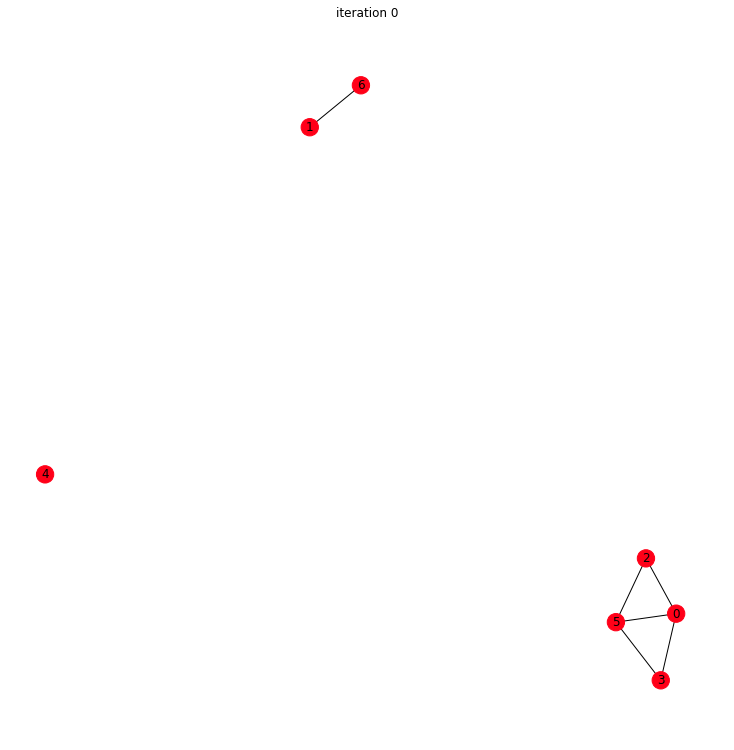

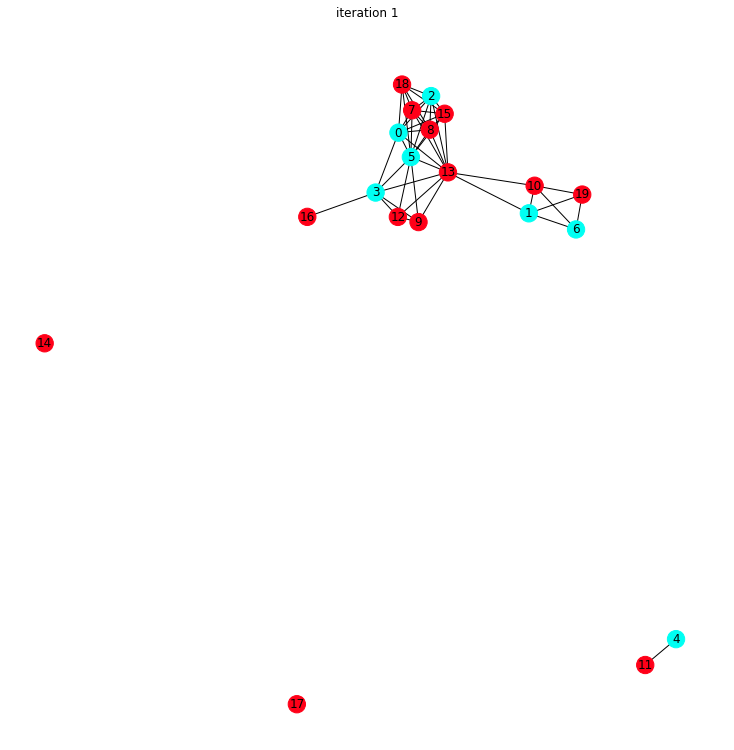

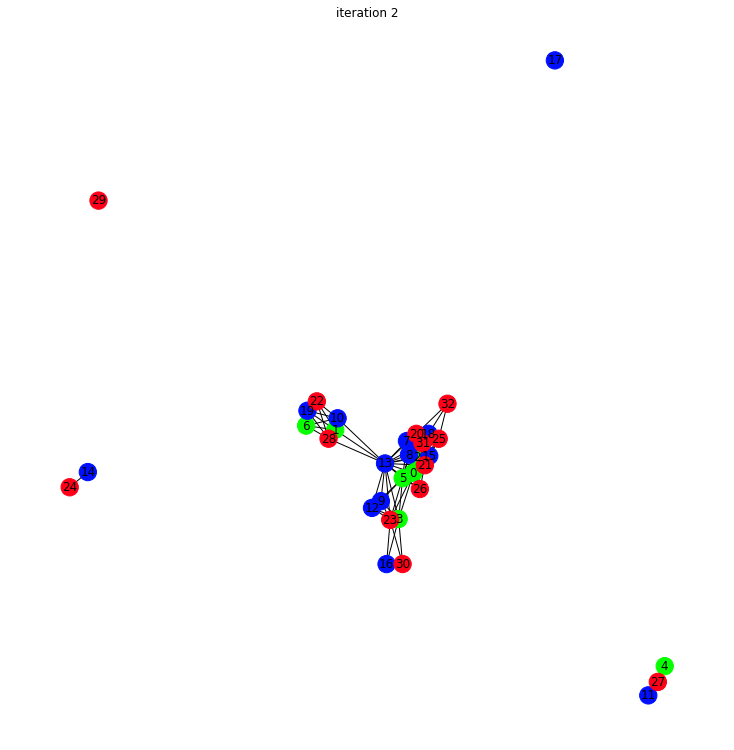

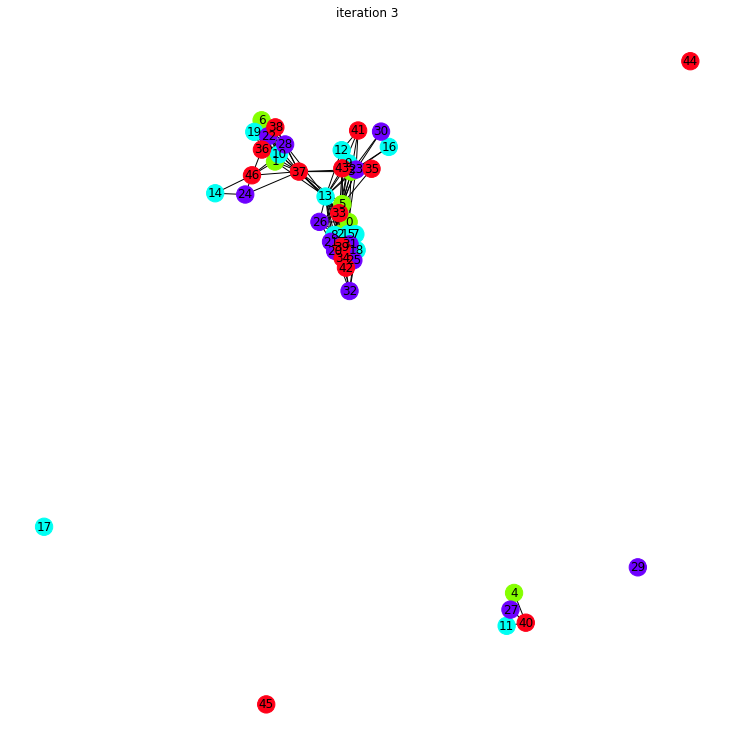

In [9]:
vcd.run()

In [19]:
points, ts_points = sample_handle(500)

found point 0
found point 1
found point 2
found point 3
found point 4
found point 5
found point 6
found point 7
found point 8
found point 9
found point 10
found point 11
found point 12
found point 13
found point 14
found point 15
found point 16
found point 17
found point 18
found point 19
found point 20
found point 21
found point 22
found point 23
found point 24
found point 25
found point 26
found point 27
found point 28
found point 29
found point 30
found point 31
found point 32
found point 33
found point 34
found point 35
found point 36
found point 37
found point 38
found point 39
found point 40
found point 41
found point 42
found point 43
found point 44
found point 45
found point 46
found point 47
found point 48
found point 49
found point 50
found point 51
found point 52
found point 53
found point 54
found point 55
found point 56
found point 57
found point 58
found point 59
found point 60
found point 61
found point 62
found point 63
found point 64
found point 65
found point 66
found

In [10]:
from pydrake.all import Sphere

def plot_points(points, name, size = 0.05, color = Rgba(0.06, 0.0, 0, 1)):
    for i, pt in enumerate(points):
        n_i = name+f"/pt{i}"
        meshcat.SetObject(n_i,
                          Sphere(size),
                          color)
        meshcat.SetTransform(n_i, 
                             RigidTransform(
                             RotationMatrix(), 
                             np.array(pt)))

In [20]:
plot_points(ts_points, 'tspts', size=0.01)

In [44]:
plot_points(ts_points, 'tspts', size=0.01)

In [22]:
import time
for p in points:
    showres(p)
    time.sleep(0.05)

In [9]:
from pydrake.all import IkCartesianWaypoint

ImportError: cannot import name 'IkCartesianWaypoint' from 'pydrake.all' (/home/peter/git/drake_vgraphbuild_russ/drake-build/install/lib/python3.8/site-packages/pydrake/all.py)

In [6]:
ik_solver = get_ik_problem_solver(plant, plant_context, [plant.GetFrameByName('ur_tool0')], np.zeros(plant.num_positions()))

In [7]:
rot = RotationMatrix.MakeXRotation(_ik_positions[3])@RotationMatrix.MakeYRotation(_ik_positions[4])@RotationMatrix.MakeZRotation(_ik_positions[5])

RollPitchYaw(_ik_positions[3],
                    _ik_positions[4],
                    _ik_positions[5]).ToRotationMatrix()
tf = RigidTransform(rot, _ik_positions[:3])



In [8]:
for slider in sliders:
    display(slider)

FloatSlider(value=0.0, description='q0', max=2.827433388230814, min=-2.827433388230814)

FloatSlider(value=0.0, description='q1', max=2.827433388230814, min=-2.827433388230814)

FloatSlider(value=0.0, description='q2', max=2.827433388230814, min=-2.827433388230814)

FloatSlider(value=0.0, description='q3', max=2.827433388230814, min=-2.827433388230814)

FloatSlider(value=0.0, description='q4', max=2.827433388230814, min=-2.827433388230814)

In [10]:

ik = InverseKinematics(plant, plant_context)
tf = plant.EvalBodyPoseInWorld(plant_context,  plant.GetBodyByName('ur_tool0'))
for pose, f in zip([tf], [plant.GetFrameByName('ur_tool0')]):
    ik.AddPositionConstraint(
        f,
        [0, 0, 0],
        plant.world_frame(),
        pose.translation(),
        pose.translation(),
    )
    # ik.AddOrientationConstraint(
    #     f,
    #     RotationMatrix(),
    #     plant_ik.world_frame(),
    #     pose.rotation(),
    #     0.0,
    # )
prog = ik.get_mutable_prog()
qik = ik.q()
prog.AddQuadraticErrorCost(np.identity(len(qik)), np.zeros(5), qik)
prog.SetInitialGuess(qik, np.zeros(5))
result = Solve(ik.prog())
if result.is_success():
    print(f"ik sol {result.GetSolution(qik)}")
    print(f"q current {q}")
    print("IK success")
    
else:
    print("IK failure")
    

ik sol [-0.07819221  0.25785377  0.50098872  0.24209873 -0.44499895]
q current [0.      0.      0.77257 0.77257 0.87257]
IK success
